In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np
import torchaudio
import torch


tensor(-103.7828) tensor(115.1181)
-0.42897514


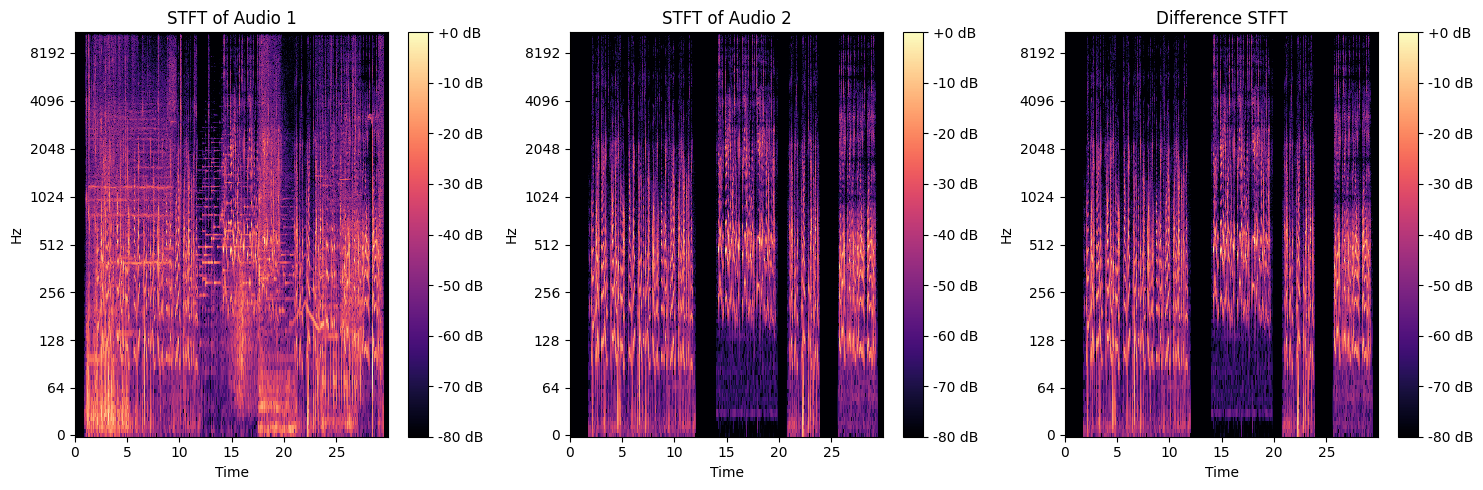

In [2]:
def process_audio(file1, file2, file3, file4):
    """Loads two audio files, calculates their STFTs, subtracts the difference, and displays the results."""
    n_fft=2**12
    try:
        # Load audio files
        y1, sr1 = librosa.load(file1)
        y2, sr2 = librosa.load(file2)
        y3, sr3 = librosa.load(file3)
        y4, sr4 = librosa.load(file4)

        y5 = y1 - (y3 + y4)

        # Check if sample rates are the same
        if sr1 != sr2:
            print(
                "Warning: Sample rates of the two audio files are different. Resampling to the first file's sample rate.")
            y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
            sr2 = sr1

        # Calculate STFTs
        stft1 = librosa.stft(y1, n_fft=n_fft)
        stft2 = np.abs(librosa.stft(y2,n_fft=n_fft))
        stft3 = np.abs(librosa.stft(y3,n_fft=n_fft))
        stft4 = np.abs(librosa.stft(y4,n_fft=n_fft))
        stft5 = librosa.stft(y5,n_fft=n_fft)
        c = torch.from_numpy(y5)
        c = torch.stft(c,n_fft=n_fft,window=torch.hann_window(n_fft),return_complex=True)
        d = torch.view_as_real(c)
        print(d.min(), d.max())
        print(y5.min())

        # Subtract the difference (handle potential shape mismatch)
        min_shape = min(stft1.shape[1], stft2.shape[1])
        diff_stft = stft1[:, :min_shape] - stft5[:, :min_shape]
        
        stft1 = np.abs(stft1)
        stft5 = np.abs(stft5)
        diff_stft = np.abs(diff_stft)

        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        librosa.display.specshow(librosa.amplitude_to_db(stft1, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 1')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 2)
        librosa.display.specshow(librosa.amplitude_to_db(stft2, ref=np.max), sr=sr2, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 2')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 3)
        librosa.display.specshow(librosa.amplitude_to_db(stft5, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('Difference STFT')
        plt.colorbar(format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("Error: One or both audio files not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage: Replace 'audio1.wav' and 'audio2.wav' with your file paths.
top_dir = "46841"
process_audio(f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/mix.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/speech.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/sfx.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/music.wav")

In [34]:
import torchaudio
import torch

def separate_audio_by_frequency(audio_file_path, frequency_ranges,n_fft=8192):
    
    waveform, sample_rate = torchaudio.load(audio_file_path)
    waveform = waveform.mean(dim=0, keepdim=True) # Convert stereo to mono

    window = torch.hann_window(n_fft)
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=512, window=window, return_complex=True)

    frequency_bands = []
    for min_freq, max_freq in frequency_ranges:
      # Calculate frequency indices
      min_index = int(min_freq * n_fft / sample_rate)
      max_index = int(max_freq * n_fft / sample_rate)

      # Extract frequency bands from STFT
      band_stft = stft[:, min_index:max_index, :]
   
      magnitudes = torch.abs(band_stft)
      angles = torch.angle(band_stft)
      

      # Recover original complex data
      recovered_data = magnitudes * torch.exp(1j * angles)
      print(band_stft)
      print(recovered_data.allclose(band_stft))
      print()
      # print(f"Band:{min_freq}-{max_freq} \t Min: {t.min()}, Max: {t.max()} Mean: {t.mean()} Std: {t.std()}")
      # print(angle.min(), angle.max())
      # band_waveform = torch.istft(band_stft, n_fft=n_fft, hop_length=512, window=window, length=waveform.shape[-1],onesided=False)
      frequency_bands.append(band_stft.squeeze())


    


In [35]:
separate_audio_by_frequency(f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/99400/mix.wav",[(0,5000),(5000,10000),(10000,15000),(15000,20000),(20000,25000)],n_fft=4096)

tensor([[[ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
           ..., -0.0704+0.0000e+00j, -0.0530+0.0000e+00j,
          -0.0390+0.0000e+00j],
         [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
           ...,  0.0385+1.9345e-02j,  0.0237+1.9984e-02j,
           0.0123+1.1111e-02j],
         [ 0.0000-0.0000e+00j,  0.0000-0.0000e+00j,  0.0000-0.0000e+00j,
           ...,  0.0004-1.6217e-02j,  0.0054-4.4875e-05j,
           0.0004-8.9278e-03j],
         ...,
         [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
           ..., -0.0045-1.3863e-02j, -0.0011+2.7943e-03j,
          -0.0012+6.8797e-04j],
         [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
           ..., -0.0143+2.5436e-03j,  0.0007+4.1041e-03j,
          -0.0005+5.0578e-04j],
         [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
           ...,  0.0203+8.4452e-03j,  0.0211-3.1977e-03j,
           0.0165-5.7763e-03j]]])
True



[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


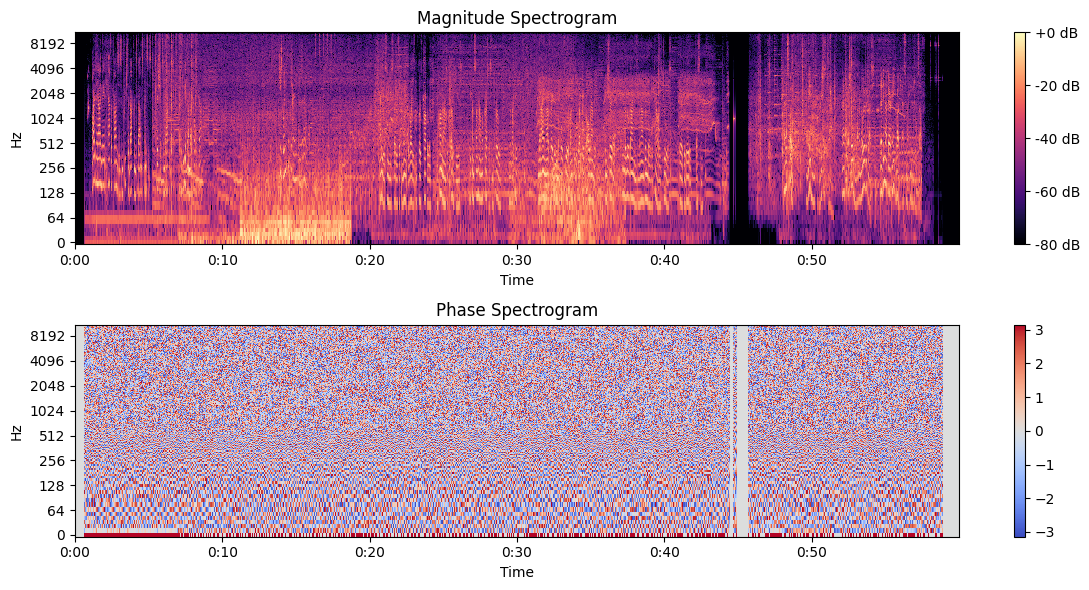

In [17]:

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def analyze_audio(audio_file_path):
    """Loads an audio file, calculates its STFT, and plots the magnitude and phase."""
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file_path)

        # Short-Time Fourier Transform (STFT)
        stft_result = librosa.stft(y)
        stft_magnitude = np.abs(stft_result)
        stft_phase = np.arctan(stft_result.real,stft_result.imag)
        istft = np.tan(stft_phase)
        print(istft)

        # Plotting
        plt.figure(figsize=(12, 6))

        # Magnitude spectrogram
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(stft_magnitude, ref=np.max),
                                 sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Magnitude Spectrogram')


        # Phase spectrogram
        plt.subplot(2, 1, 2)
        librosa.display.specshow(stft_phase, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar()
        plt.title('Phase Spectrogram')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: Audio file not found at {audio_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
audio_file_path = "/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/9054/mix.wav"  # Replace with your audio file path
analyze_audio(audio_file_path)

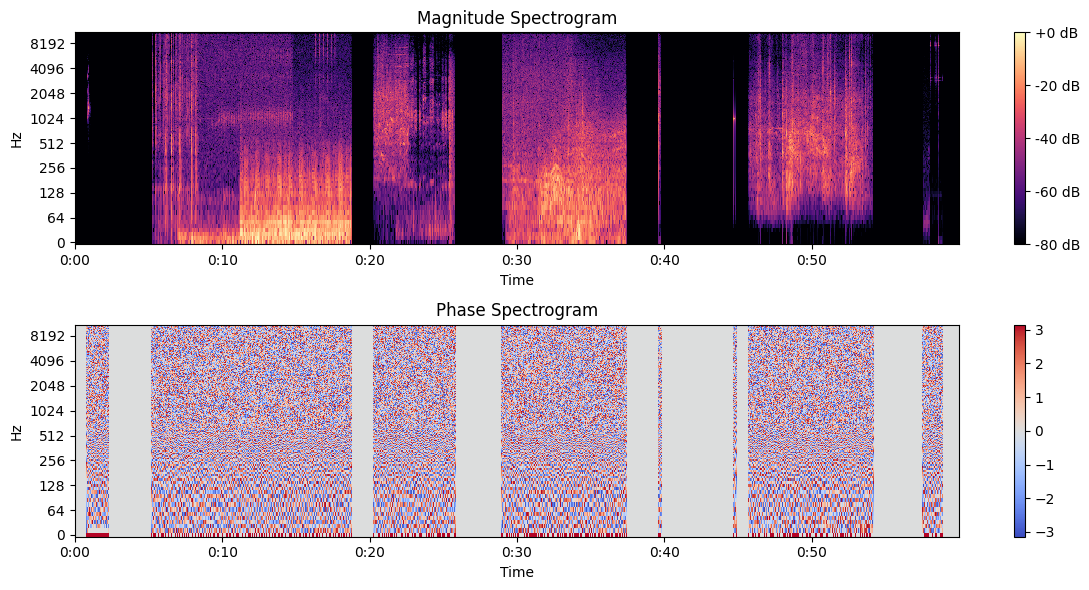

In [6]:
analyze_audio("/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/9054/sfx.wav")